## 1 Плюсы и минусы модели
### Microsoft COCO

1. Сначала определяет, объекты каких классов имеются на изображении. Для каждой обнаруженной категории отдельный экземпляр будет помечен, проверен и, наконец, сегментирован.
2. Сегментируются не по типу объекта, а каждый объект индивидуально, чтобы распознать даже самые маленькие объекты при перекрытии сцен. То есть, если на фото будет 5 собак, которые дерутся, система должна распознать и пометить каждую из них не сливая в одно изображение.
3. Набор данных MS COO (Microsoft Common Objects in COntext) содержит 91 общую категорию объектов, 82 из которых имеют более 5K помеченных примеров. Набор данных содержит в общей сложности 328 000 изображений и 2,5 миллиона помеченных экземпляров. В сравнении с набором данных ImageNet, COCO имеет меньше категорий объектов, но каждая категория имеет больше экземпляров.
4. Кроме того, насколько я поняла, сначала изображение делится на объекты и наполнитель (то, что не нужно определять до конкретного объекта, например небо, деревья и т.д.), и из этой выборки классифицируются экземпляры объектов, а наполнитель служит вспомогательным элементом.
5. При детектировании используется иерархическое аанотирование: сначала определяется тип, затем подтип и так далее.
6. Цель - собрать нестандартные сцены и изображения с несколькими видами и объектами на картинках, содержащих контекстную информацию.

*Использована информация из статьи "Microsoft COCO: Common Objects in Context"*

## 2 Детектирование.

In [2]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
# from six.moves.urllib.request import urlopen
# from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time
%matplotlib inline

In [3]:
from google.colab import files

In [4]:
import cv2 as cv

Загрузим картинку

In [ ]:
# files.upload()

## OpenCV - Selectiv Search

https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

(3968, 1984, 3)


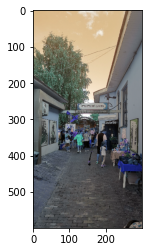

In [6]:
#Читаем картинку
# im = cv.imread('candyshop.jpg')
# im = cv.imread('pier.jpg')
im = cv.imread('/content/drive/MyDrive/Neural networks/street.jpg')
print(im.shape)
# размеры изображения
newH = 600  #высота
newW = int(im.shape[1]*newH/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

Selective Search(селективный поиск)

In [7]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [8]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(6167, 4)


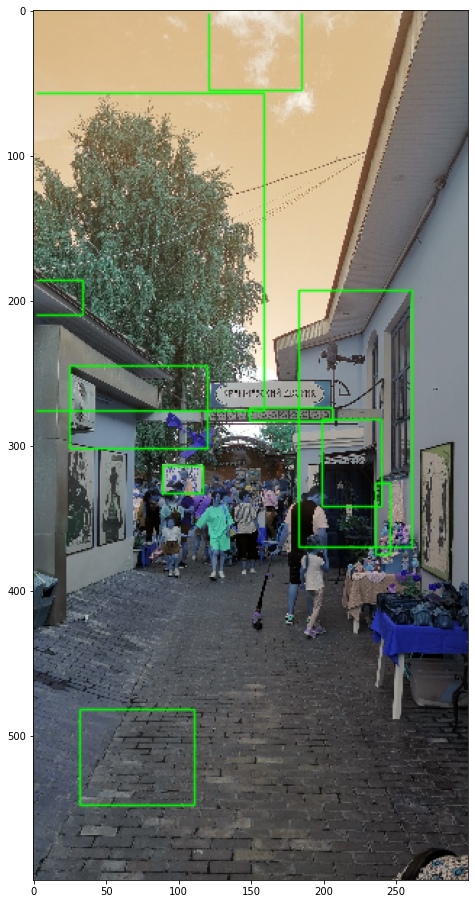

In [52]:
#Построим области

num_Rects = 10 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
  else: 
    break 

# Рисуем на экран
plt.figure(figsize=(9,16))
plt.imshow(im_) 
plt.show()

https://github.com/opencv/opencv/tree/master/data/haarcascades

<Figure size 648x1152 with 0 Axes>

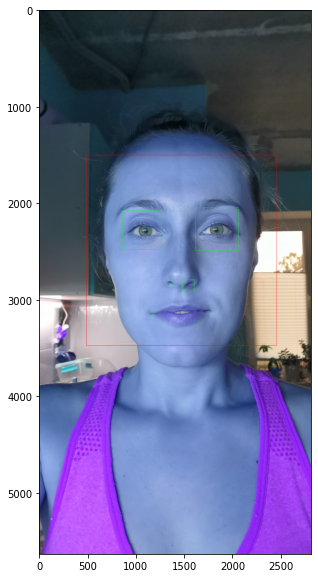

In [53]:
imf = cv.imread('/content/drive/MyDrive/Neural networks/me.jpg')
plt.figure(figsize=(9,16))

face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

gray = cv.cvtColor(imf, cv.COLOR_RGB2GRAY)
# print(gray)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)


for (x,y,w,h) in faces:
     cv.rectangle(imf,(x,y),(x+w,y+h),(255,0,0),2)
     roi_gray = gray[y:y+h, x:x+w]
     roi_color = imf[y:y+h, x:x+w]

     eyes = eye_cascade.detectMultiScale(roi_gray)
     for (ex,ey,ew,eh) in eyes:
         cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(imf)      
plt.show()   

## **Формирование и обработка результатов детектирования**


Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей

In [44]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(15, 20))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [54]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Формируем тензор

In [55]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Выполняем детектор

In [67]:

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=30)

  display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов

In [68]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=30, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [69]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=30, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

Чтение имен кадров 

In [59]:
root_path = '/content/drive/MyDrive/Neural networks/'
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('/content/drive/MyDrive/Neural networks/street.jpg', dtype='<U49')

In [50]:
List_name[1]

array('/content/drive/MyDrive/Neural networks/me.jpg', dtype='<U45')

Проверяем детектор

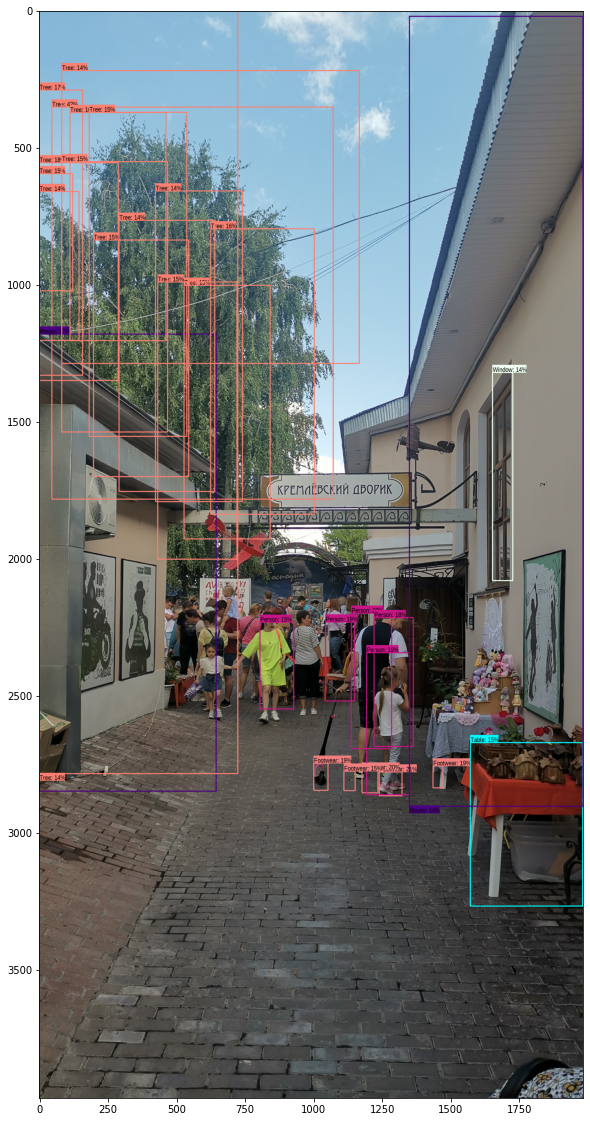

In [70]:
result = run_detector(detector, List_name[0])

Если брать max_boxes меньше, он не находит стол и окно

In [66]:
result

{'detection_boxes': array([[8.94445330e-02, 2.33160257e-02, 4.49453712e-01, 5.40845633e-01],
        [5.54626942e-01, 5.73733091e-01, 6.78858757e-01, 6.48337960e-01],
        [7.00558305e-01, 6.25272989e-01, 7.22198844e-01, 6.67832136e-01],
        [6.98790371e-01, 5.93633950e-01, 7.19332397e-01, 6.23299062e-01],
        [5.62509894e-01, 5.26451051e-01, 6.35078311e-01, 5.80473125e-01],
        [6.92461193e-01, 5.04671931e-01, 7.17040122e-01, 5.31285167e-01],
        [6.95030630e-01, 7.23818481e-01, 7.14796722e-01, 7.42898762e-01],
        [5.90800583e-01, 6.02049530e-01, 7.21095145e-01, 6.81529701e-01],
        [5.58646679e-01, 6.15923405e-01, 6.76705122e-01, 6.88066244e-01],
        [1.40487731e-01, 0.00000000e+00, 3.40464652e-01, 1.45754129e-01],
        [2.98083365e-01, 0.00000000e+00, 7.17846215e-01, 3.25629056e-01],
        [7.37049729e-02, 0.00000000e+00, 3.35458338e-01, 8.01810250e-02],
        [9.44395289e-02, 5.66827059e-02, 3.03812057e-01, 2.33679026e-01],
        [2.01166376